# FSA Assignment
 Implement the FSA variable selectionmethod for linear models and binary classification with the logistic loss, as
 described in the slides. Use the parameters s = 0.0001, μ = 30, N iter = 500. Take special care to normalize each column of the X matrix to have zero mean and variance 1 and to use the same mean and standard deviation that you used for normalizing the train set also for normalizing the test set.


#### Import dependencies

In [355]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Data loading functions

In [356]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    test_x = np.loadtxt(path+"gisette_test.data")

    return train_x, train_y, valid_x, valid_y, test_x



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [357]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)

def hofx():
    h=0
    beta1s=[]
    beta0s=[]
    p=1/(1+np.exp(-h))
    w_i=(p)*(1-p)
    mean_x = np.average(train_x, axis=0)
    mean_y = np.average(train_y, axis=0)
    beta_1= np.sum(w_i*(train_y-mean_y)*(train_x*mean_x))/(np.sum(w_i*np.square(train_x-mean_x)))
    beta_0= mean_y + beta_1 * mean_x






#### Find k for 10, 30, 100, 300, 500 features

#### Plot the error vs iteration and display final error in a table

## a) Gisette

Using the Gisette data, train a FSA classifier on the training set, starting with β(0) = 0 to select k ∈ {10, 30, 100, 300, 500} features. Plot the training loss vs iteration number for k = 30. Report in a table the misclassification errors on the training and test set for the models obtained for all these k. Plot the misclassification error on the training and test set vs k.

In [364]:
#train_x, train_y, test_x, test_y, _ = get_gisette()

In [365]:
#calibrate_k(train_x, train_y, test_x, test_y)

In [366]:
#plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);

## b) Dexter
Repeat point a) on the dexter dataset

In [367]:
train_x, train_y, test_x, test_y = get_dexter()

In [368]:
#calibrate_k(train_x, train_y, test_x, test_y)

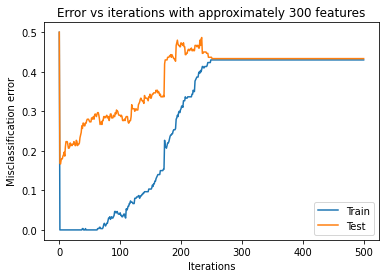

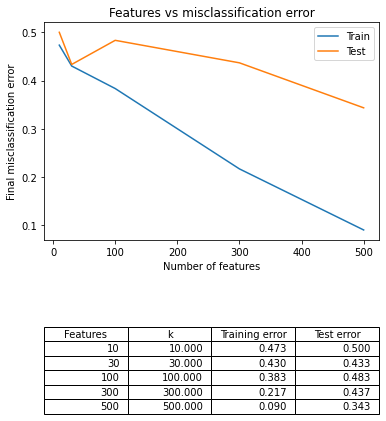

In [369]:
plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);

## c) Madelon
Repeat point a) on the madelon dataset

In [370]:
train_x, train_y, test_x, test_y = get_madelon()

In [371]:
#calibrate_k(train_x, train_y, test_x, test_y)

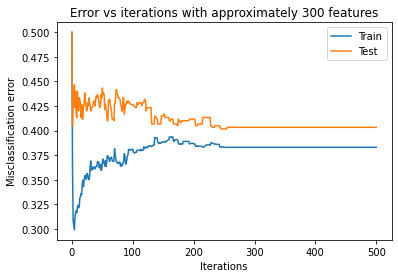

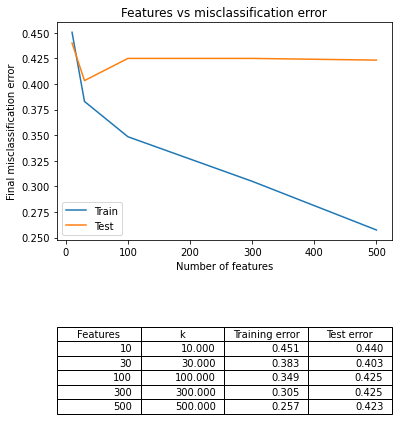

In [372]:
plot_fsa(train_x, train_y, test_x, test_y, [10, 30, 100, 300, 500]);
